In [1]:
from LiteML import clean_dataset, load_file, get_feature_names, evaluate_aggregated_features, evaluate_silhouette_score, train_and_evaluate_model, load_trained_model, evaluate_loaded_model

# ds_path = "../ds/hldddosdn_hlddos_combined_binary_cleaned_0d1n_reduced.csv"
ds_path = "../ds/insdn_ddos_binary_0n1d.csv" #good

# ds_path = "../ds/lr-hr_ddos_2024_binary_cleaned.csv"

X, y = load_file(ds_path)

✅ Dataset loaded successfully! >> insdn_ddos_binary_0n1d.csv
✅ Features and target extracted successfully!


In [6]:
def train_on_feature_set(X_set, y, label, model, save_path=None):
    print(f"✅ Training classifier on {label} features with 5-Fold CV...")
    results = train_and_evaluate_model(X_set, y, model=model, save_path=save_path)
    return results

def print_evaluation_result(title, result):
    print(f"\nEvaluation Result for: {title}")
    print("\nClassification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])

def print_result_summary(results_dict):
    print("\nResult Summary (5-Fold CV Average):")
    print("=" * 115)
    print(f"{'Method':<15}{'Feature':<10}{'Accuracy':<10}{'Train Time (s)':<15}{'Test Time (s)':<15}{'Inference time (μs)':<15}")
    # print(f"{'Method':<15}{'Feature':<10}{'Accuracy':<10}{'ROC-AUC':<10}{'MSE':<10}{'R2':<10}{'Train Time (s)':<15}{'Test Time (s)':<15}{'Inference time (μs)':<15}")
    print("=" * 115)

    for label, (X_set, result) in results_dict.items():
        print(f"{label:<15}{X_set.shape[1]:<10}"
              f"{result['accuracy']:<10.6f}"
              # f"{result['roc_auc']:<10.6f}"
              # f"{result['mse']:<10.6f}"
              # f"{result['r2']:<10.6f}"
              f"{result['training_time']:<15.6f}"
              f"{result['testing_time']:<15.6f}"
              f"{result['inference_time_per_sample_ms']:<15.6f}")
    print("=" * 115)
    
def print_detailed_evaluation(results_dict):
    for label, (_, result) in results_dict.items():
        print(f"Evaluation Result for: {label}")
        print("\nClassification Report:")
        print(result['classification_report'])
        print("Confusion Matrix:")
        print(result['confusion_matrix'])
        print("=" * 115)


In [7]:
# Update the T_adaptive formula

import numpy as np
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_calc(X, variance_threshold=0.05):

    selector = VarianceThreshold(threshold=variance_threshold)
    X_selected = selector.fit_transform(X)
    selected_indices = np.where(selector.get_support())[0]  # Get indices

    return X_selected, selected_indices


# Dynamic Feature Analysis (DFA)
def dynamic_feature_analysis(X, epsilon=1e-10):
    v = np.var(X, axis=0)
    T_adaptive = np.sqrt(np.median(v))
    S_variance = np.where(v > T_adaptive)[0]
    if len(S_variance) == 0:
        S_variance = np.array([np.argmax(v)])
        
    X_selected = X[:, S_variance]
    V_selected = v[S_variance]
    ranks = V_selected / (np.sum(V_selected) + epsilon)
    f_aggregated = X_selected @ ranks

    print(f"Selected features (Variance): {len(S_variance)} | Indices: {[int(i) for i in S_variance]}")
    return X_selected, f_aggregated, S_variance


Dataset: ../ds/insdn_ddos_binary_0n1d.csv
Dataset counts: 190366 samples, 77 features

✅ Cleaning dataset...
Removed 14 constant numeric features: ['Bwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd URG Flags', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Blk Rate Avg', 'Fwd Byts/b Avg', 'Fwd PSH Flags', 'Fwd Pkts/b Avg', 'Fwd Seg Size Min', 'Fwd URG Flags', 'Init Fwd Win Byts', 'URG Flag Cnt']
Total features removed: 14
Retained 63 clean numeric features

✅ Normalizing data...
Scaler used: MinMaxScaler()

✅ Running Dynamic Feature Analysis (DFA)...
Selected features (Variance): 12 | Indices: [0, 1, 15, 20, 25, 30, 34, 41, 43, 44, 45, 53]
DFA completed in 0.0802 seconds

Selected features: 12 | Indices: [ 0  1 15 20 25 30 34 41 43 44 45 53]
Selected feature names (DFA): ['Protocol', 'Flow Duration', 'Flow Pkts/s', 'Fwd IAT Tot', 'Bwd IAT Tot', 'Bwd PSH Flags', 'Bwd Pkts/s', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Down/Up Ratio', 'Init Bwd Win Byts']


✅ Training classifier

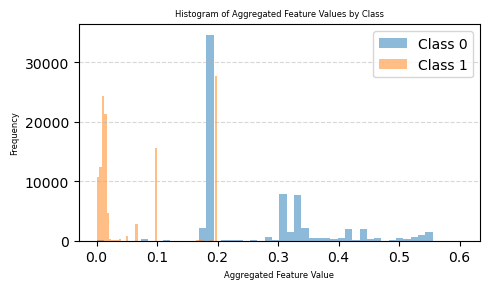

Average Silhouette Score: 0.4580

🎉 Analysis complete!


In [8]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# 1. Info asas dataset
print(f"Dataset: {ds_path}")
print(f"Dataset counts: {X.shape[0]} samples, {X.shape[1]} features")

# 2. Clean dataset
print("\n✅ Cleaning dataset...")
X_cleaned, valid_indices = clean_dataset(X, y)

# Convert cleaned data back into a DataFrame to preserve feature names
if isinstance(X, pd.DataFrame):
    cleaned_feature_names = X.columns[valid_indices].tolist()
    X_cleaned_df = pd.DataFrame(X_cleaned, columns=cleaned_feature_names)
else:
    cleaned_feature_names = [f"feature_{i}" for i in range(X_cleaned.shape[1])]
    X_cleaned_df = pd.DataFrame(X_cleaned, columns=cleaned_feature_names)

# 3. Normalize
print("\n✅ Normalizing data...")
scaler = MinMaxScaler()
print("Scaler used:", scaler)
X_scaled = scaler.fit_transform(X_cleaned_df)

# 4. Dynamic Feature Analysis (DFA)
print("\n✅ Running Dynamic Feature Analysis (DFA)...")
dfa_start_time = time.time()
X_selected, aggregated_feature, selected_indices = dynamic_feature_analysis(X_scaled)
print(f"DFA completed in {time.time() - dfa_start_time:.4f} seconds")

print(f"\nSelected features: {len(selected_indices)} | Indices: {selected_indices}")
feature_names_dfa = get_feature_names(cleaned_feature_names, selected_indices)
print("Selected feature names (DFA):", feature_names_dfa if feature_names_dfa else "[Feature names not available]")
print("\n")

# 5. Train & Evaluate
model = 'dt'
results_full = train_on_feature_set(X_cleaned, y, "full", model=model)
results_selected = train_on_feature_set(X_selected, y, "selected", model=model)
X_agg = aggregated_feature.reshape(-1, 1)
results_agg = train_on_feature_set(X_agg, y, "aggregated", model=model)

# 7. Kumpulkan hasil
results_dict = {
    "Full Features": (X_cleaned, results_full),
    "DFA Sel": (X_selected, results_selected),
    "DFA Agg": (X_agg, results_agg)
}

# 8. Papar hasil
print(f"\nModel: {results_selected['model']}")
print_result_summary(results_dict)
print_detailed_evaluation(results_dict)

# 9. Tambahan: Silhouette score untuk f_agg
print("\n✅ Evaluate Aggregated Feature (X_agg)...")
evaluate_aggregated_features(X_agg, y)
score = evaluate_silhouette_score(X_agg, y, sample_size=10000, random_state=42, apply_scaler=False)

print("\n🎉 Analysis complete!")